# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

### 1. Is the distribution of body temperatures normal? ###
We first visually compare the distribution of the temperature data with a randomly generated theoretical normal curve based on the data. We make use of a histogram *and* also the Empirical Cumulative Distribution Function or ECDF.

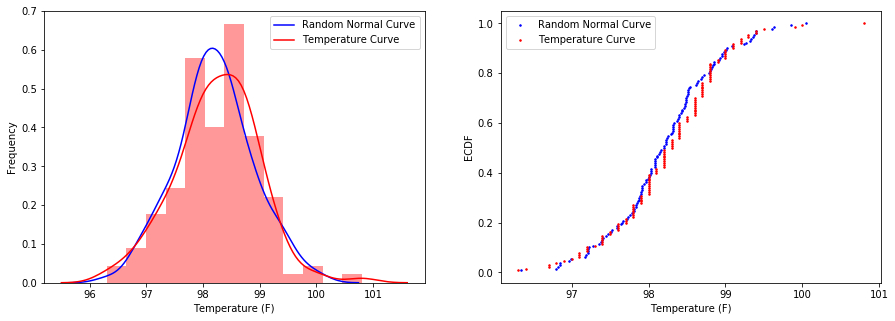

In [20]:
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def ECDF(data):
    """Produces the x and y for empirical CDF plot"""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

#ignore FutureWarning message
warnings.simplefilter(action="ignore", \
                      category=FutureWarning)

#temperature data statistics
temp_mean = np.mean(df["temperature"])
temp_std = np.std(df["temperature"])
temp_len = len(df["temperature"])

#randomly generated normal curve based on temp statistics
np.random.seed(42)
true_normal = np.random.normal(temp_mean, temp_std, size=temp_len)

f, axes = plt.subplots(1, 2, figsize=(15,5))

#distribution plots
ax = sns.distplot(true_normal, kde=True, hist=False, color="blue", \
                  label="Random Normal Curve", ax=axes[0])
ax = sns.distplot(df["temperature"], kde=True, color="red", \
                  kde_kws={"label": "Temperature Curve"}, ax=axes[0])
ax.set(xlabel="Temperature (F)", ylabel="Frequency")

#getting ECDF coordinates
temp_x, temp_y = ECDF(df["temperature"])
true_x, true_y = ECDF(true_normal)

#ECDF plots
plt.plot(true_x, true_y, linestyle="none", marker=".", \
         markersize=3, color="blue", label="Random Normal Curve")
plt.plot(temp_x, temp_y, linestyle="none", marker=".", \
         markersize=3, color="red", label="Temperature Curve")

plt.xlabel("Temperature (F)")
plt.ylabel("ECDF")
plt.legend()
plt.show()

Visually it appears they are close. But in order to verify probabilistically, we can perform a Normality test. A common general-purpose approach I found is the **Shapiro-Wilk** test. Since our *P-value* is greater than the critical value (set at 5%), the null hypothesis that assumes the data is normal should not be rejected. Therefore, the Temperature function *is* a normal distribution.

In [3]:
import scipy.stats as stats

alpha = 0.05

stat, p = stats.shapiro(df["temperature"])

print("W-Statistic: %.3f" % stat)
print("P-Value: %.3f" % p)
print("alpha: %.3f\n" % alpha)
print("P-Value larger than alpha? %s" % str(p > alpha))

if p > alpha:
    print("Temperature Curve appears Normal")
else:
    print("Temperature Curve does NOT appear Normal")

W-Statistic: 0.987
P-Value: 0.233
alpha: 0.050

P-Value larger than alpha? True
Temperature Curve appears Normal


### 2. Is the sample size large? Are the observations independent? ###
The sample size is 130. The data is about the human body temperature. Therefore, this sample is actually a minute sampling of the human population at the time of the experiment. Following the 10% rule, it would take that the human population around the 1860's be *less* than 1,300 for the observations to be considered dependent. Therefore, the sample entries can be said to be **independent** of each other.

In [4]:
print(len(df["temperature"]))

130


### 3. Is the true population mean really 98.6 degrees F? ###
Since we will be comparing our dataset with a set mean value, we'll be performing a one-sample Bootstrap approach.
* Our **null hypothesis** is that our `temp_mean` (mean of the temperature data) is equal to `98.6`.
* Our **alternative hypothesis** is that our `temp_mean` is *not* equal to `98.6`.

Our observed test statistic is the difference between the actual mean of the sample *and* the hypothetical mean, which is `98.6`.

We shift our population mean accordingly to produce `shifted_temp`.

In [5]:
alpha = 0.05

temp_size = len(df["temperature"])
temp_mean = np.mean(df["temperature"])
temp_std = np.std(df["temperature"])
null_mean = 98.6

test_stat = temp_mean - null_mean
print("The difference of means: %.2f\n" % test_stat)

shifted_temp = df["temperature"] - temp_mean + null_mean
print("The mean of 'shifted_temp': %.1fF" % np.mean(shifted_temp))

The difference of means: -0.35

The mean of 'shifted_temp': 98.6F


We'll now perform a simulation of 10,000 trials using the shifted data. For every loop, a combination with replacement is done on the `shifted_temp` and the difference of its mean and `98.6` is appended to the `simulation` list (which is later turned into an array).

From there, the number of instances where the difference is at or below `-0.35` is tallied and divided by the number of trials (10,000). This gave us the `p`, which is our p-value. And since the `p` is almost non-existent and therefore less than our critical value `alpha`, we end up rejecting our null hypothesis and conclude that the true population mean is *not* 98.6F.

In [6]:
simulation = []

for i in range(10000):
    trial = np.random.choice(shifted_temp, size=temp_size)
    trial_mean = np.mean(trial)
    simulation.append(trial_mean - null_mean)
simulation = np.array(simulation)

p = np.sum(simulation <= test_stat)/10000

print("P-Value: %.7f" % p)
print("P-Value larger than alpha? %s" % str(p > alpha))
if p > alpha:
    print("The true population mean is 98.6F")
else:
    print("The true population mean is NOT 98.6F")

P-Value: 0.0000000
P-Value larger than alpha? False
The true population mean is NOT 98.6F


Another approach is the one-sample statistical test. We use one-sample because, again, we are comparing one dataset with a given value. In this instance, we would usually opt for a *z-test* since it is generally accepted for any sample where **n > 30**. Though this is true in our case because we have 130 samples, we will use a *t-test* instead because what we are given is a *mean*, not a *proportion*. In this scenario, the *t-test* is more appropriate to use. It is also worth noting that since the populaton variance or standard deviation is unknown, we really have to use the *t-test*.

In [7]:
T = (temp_mean-null_mean)/(temp_std/(temp_size**0.5))
print("T-statistic: %.3f" % T)

T-statistic: -5.476


In [8]:
p = stats.ttest_1samp(df["temperature"], null_mean)[1]

print("P-Value: %.7f" % p)
print("P-Value larger than alpha? %s" % str(p > alpha))
if p > alpha:
    print("The true population mean is 98.6F")
else:
    print("The true population mean is NOT 98.6F")

P-Value: 0.0000002
P-Value larger than alpha? False
The true population mean is NOT 98.6F


If we have to use the *z-test* just because it satisfies the **n>30** criteria, we could compute the Z-statistic as follows.

In [9]:
from statsmodels.stats import weightstats as weight

Z = weight.ztest(df["temperature"],value=null_mean)
print("Z-statistic: %.3f\n" % Z[0])

p = Z[1]
print("P-Value: %.7f" % p)
print("P-Value larger than alpha? %s" % str(p > alpha))
if p > alpha:
    print("The true population mean is 98.6F")
else:
    print("The true population mean is NOT 98.6F")

Z-statistic: -5.455

P-Value: 0.0000000
P-Value larger than alpha? False
The true population mean is NOT 98.6F


In either approach, we get to the same conclusion that the true mean is very highly likely not 98.6F.

### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests. ###
We use 10 random integers to draw 10 indices from `df`.

In [10]:
np.random.seed(24)
rand_ind = np.random.randint(1, len(df), 10)

df_sample = df.iloc[rand_ind]
display(df_sample[["temperature"]])

,temperature
88,98.7
101,98.5
124,97.5
5,99.2
83,99.2
124,97.5
116,100.8
74,99.0
19,99.4
120,97.7


Since we have much less than 30 trials, it is more appropriate to use the *t-test* for this sample of samples.

In [11]:
alpha = 0.05

T = stats.ttest_1samp(df_sample["temperature"], null_mean)
p = T[1]

print("T-statistic: %.3f" % T[0])
print("P-Value: %.7f" % p)
print("P-Value larger than alpha? %s" % str(p > alpha))
if p > alpha:
    print("The true population mean is 98.6F")
else:
    print("The true population mean is NOT 98.6F")

T-statistic: 0.465
P-Value: 0.6533142
P-Value larger than alpha? True
The true population mean is 98.6F


If we make use of *z-test* instead, we still arrive to the same conclusion.

In [12]:
Z = weight.ztest(df_sample["temperature"],value=null_mean)
p = Z[1]

print("Z-statistic: %.3f" % Z[0])
print("P-Value: %.7f" % p)
print("P-Value larger than alpha? %s" % str(p > alpha))
if p > alpha:
    print("The true population mean is 98.6F")
else:
    print("The true population mean is NOT 98.6F")

Z-statistic: 0.465
P-Value: 0.6422822
P-Value larger than alpha? True
The true population mean is 98.6F


This time, both frequentist approaches approved of the likelihood that the true population *is* 98.6F. I believe this is because since the sample has been greatly reduced, the frequency of even the central tendency of the original sample is less pronounced (and less sharp, as seen below). The tails of the curve would consequently become fatter due to the presence of even just *one* deviating sample.

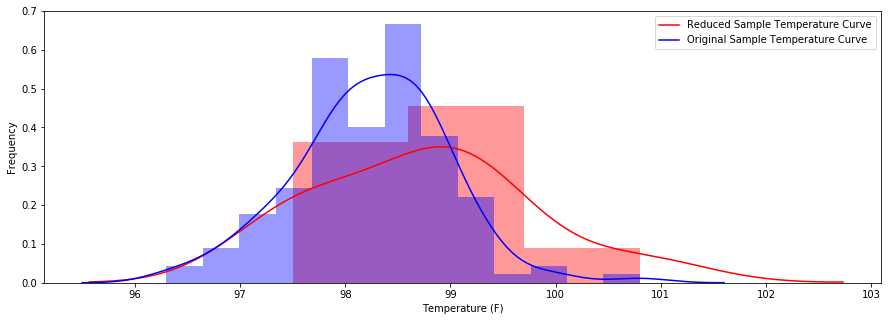

In [13]:
f, axes = plt.subplots(1, 1, figsize=(15,5))
ax = sns.distplot(df_sample["temperature"], kde=True, color="red", \
                  kde_kws={"label": "Reduced Sample Temperature Curve"})
ax = sns.distplot(df["temperature"], kde=True, color="blue", \
                  kde_kws={"label": "Original Sample Temperature Curve"})
ax.set(xlabel="Temperature (F)", ylabel="Frequency")
plt.show()

### 5. At what temperature should we consider someone's temperature to be "abnormal"? ###

If we repeat the sampling 10,000 times and get each trial's mean, we could determine the confidence interval. Below, we perform the simulation of trials using random combination with replacement. We plot the mean of every element in the array and the center 95% will contain the true mean temperature of the human body.

That 95% confidence interval points are equivalent to the function's 2.5th percentile and its 97.5th percentile. From the simulation, we therefore say that we have 95% confidence that the true mean temperature of the human body is between **98.12F and 98.38**, inclusive.

We can then confidently say that our null hypothesis earlier that claimed the true mean as 98.6F *cannot* be true.

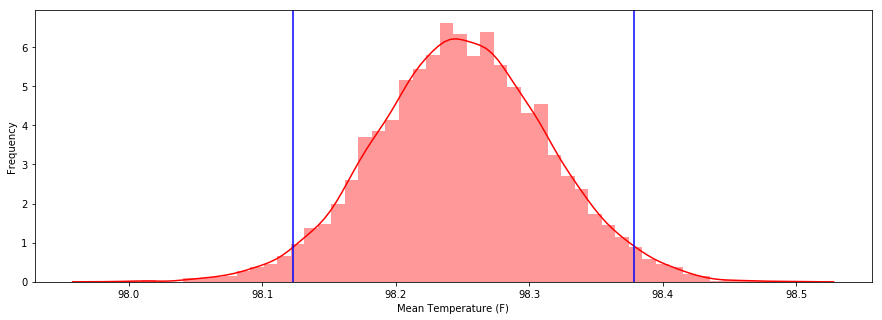

True value is between 98.12F and 98.38F, with 95% confidence.


In [14]:
simulation_mean = []

#simulation of trials
for i in range(10000):
    trial = np.random.choice(df["temperature"], size=temp_size)
    trial_mean = np.mean(trial)
    simulation_mean.append(trial_mean)
simulation_mean = np.array(simulation_mean)

f, axes = plt.subplots(1, 1, figsize=(15,5))
ax = sns.distplot(simulation_mean, kde=True, color="red")
ax.set(xlabel="Mean Temperature (F)", ylabel="Frequency")

#confidence intervals
confidence = np.percentile(simulation_mean, [2.5, 97.5])

plt.axvline(x=confidence[0], color="blue")
plt.axvline(x=confidence[1], color="blue")
plt.show()

print("True value is between %.2fF and %.2fF, with 95%% confidence." \
      % (confidence[0], confidence[1]))

Now we'll try this using the frequentist approach. By making use of the temperature dataset alone, we can compute the **standard error** by dividing the sample standard deviation by the square root of the number of samples.

The **margin of error** is twice the standard error. And the confidence interval points are the true mean *plus* the margin of error, and the true mean *minus* the margin of error.

As we can see, we arrive to the same conclusion as we had with the bootstrap approach: that the true mean temperature of the human body is between **98.12F and 98.38**, inclusive.

In [15]:
margin = 2*(temp_std/(temp_size)**0.5)

print("True value is between %.2fF and %.2fF, with 95%% confidence." \
      % (temp_mean-margin, temp_mean+margin))


True value is between 98.12F and 98.38F, with 95% confidence.


### 6. Is there a significant difference between males and females in normal temperature? ###

Our goal is to find out if male normal body temperatures are significantly different from female normal body temperatures. We first take a look at the **summary statistics** of each by separating the dataframe by gender. From the tables, how the two groups differ (or not) is not yet evident.

In [16]:
M = df[df["gender"] == "M"]["temperature"]
F = df[df["gender"] == "F"]["temperature"]

display("Male Temperature Data Stats", \
      pd.DataFrame(M.describe()))

display("Female Temperature Data Stats", \
      pd.DataFrame(F.describe()))

'Male Temperature Data Stats'

,temperature
count,65.000000
mean,98.104615
std,0.698756
min,96.300000
25%,97.600000
50%,98.100000
75%,98.600000
max,99.500000


'Female Temperature Data Stats'

,temperature
count,65.000000
mean,98.393846
std,0.743488
min,96.400000
25%,98.000000
50%,98.400000
75%,98.800000
max,100.800000


Plotting M vs. F gives us a more intuitive judgment of their difference. Both distribution and empirical ECDF help us see clearer that there *could* be statistical difference between Male and Female normal body temperatures even though their distributions are similar.

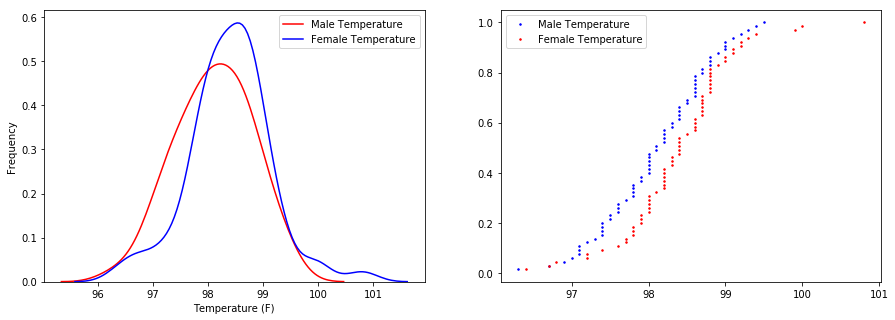

In [17]:
#getting ECDF coordinates
M_x, M_y = ECDF(M)
F_x, F_y = ECDF(F)

f, axes = plt.subplots(1, 2, figsize=(15,5))

#distribution plots
ax = sns.distplot(M, kde=True, hist=False, color="red", \
                  kde_kws={"label": "Male Temperature"}, ax=axes[0])
ax = sns.distplot(F, kde=True,hist=False, color="blue", \
                  kde_kws={"label": "Female Temperature"}, ax=axes[0])
ax.set(xlabel="Temperature (F)", ylabel="Frequency")

#ECDF plots
plt.plot(M_x, M_y, linestyle="none", marker=".", \
         markersize=3, color="blue", label="Male Temperature")
plt.plot(F_x, F_y, linestyle="none", marker=".", \
         markersize=3, color="red", label="Female Temperature")
plt.legend()

plt.show()

We then formally test this finding.
* Our **null hypothesis** is there is NO difference between Male and Female normal body temperatures.
* Our **alternative hypothesis** is there IS difference between Male and Female normal body temperatures.

Our null hypothesis can be interpreted as getting zero upon subtracting one group's mean with the other. The actual mean difference from the dataset is -0.29. This will serve as our observed **test statistic**.

In [18]:
#getting the mean of groups
M_mean = np.mean(M)
F_mean = np.mean(F)
MF_mean = M_mean-F_mean
print("The difference of means: %.2f" % MF_mean)

The difference of means: -0.29


We'll make use of **permutation** in our hypothesis testing. We do this by shuffling the original dataset and labeling the first half as the `Male` group and the next half as the `Female` group. Our original sample had 65 female entries and 65 male entries, so the proportions are equal and should not be a problem. The difference between the means of the two groups are taken and appended to our `simulation` array. Our p-value is the proportion of the total events where the `simulation` element is equal or *less* than the empirical -0.29.

In [19]:
#simulation of trials
simulation = []
for i in range(10000):
    perm_temp = np.random.permutation(df["temperature"])
    perm_M = perm_temp[:len(M)]
    perm_F = perm_temp[len(F):]
    simulation.append(np.mean(perm_M) - np.mean(perm_F))
simulation = np.array(simulation)

#getting p-value
p = np.sum(simulation <= MF_mean)/10000

print("P-Value: %.7f" % p)
print("P-Value larger than alpha? %s" % str(p > alpha))
if p > alpha:
    print("Male and Female temperature DO have significant difference.")
else:
    print("Male and Female temperature do NOT have significant difference.")

P-Value: 0.0119000
P-Value larger than alpha? False
Male and Female temperature do NOT have significant difference.


This brings us to conclude that despite our initial suspicion, there is actually no statistical difference between Male and Female body temperatures in terms of mean and general distribution. This then tells us that there is no risk in performing a general approach in medicine when it comes to gender and its intersection with temperature. This is the case with some clinical trials: underrepresented groups are wrongly diagnosed because their diagnosis are inferred from statistics of major groups. At least for this experiment, temperature can be said to be similar for both genders and that definining a standard of what's a normal range for *all* shouldn't be a risk.

Now, for this activity as a whole, a big takeaway is how wrong Carl Wunderlich was when he declared the standard normal body temperature at the time. As we have seen, 98.6F is not even within our confidence intervals and is just too high of a value. The consequence must have been dire in the medical field. For around 120 years, misdiagnosis must have been prevalent. This shows just how critical statistical understanding is and its application in the real world has far-reaching effects.